In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [38]:
E = [100, 100, 100] # suppliers capacity
D = [20, 20] # plants capacity
W = [20, 20] # DCs capacity
d = [100, 100, 100] # customers capacity

In [39]:
supply = [10, 10, 10]
demand = [80, 80, 80]

In [40]:
dummy_supply = max(0, sum(demand) - sum(supply))
# dummy_demand = max(0, sum(supply) - sum(demand))

In [41]:
# suppliers-plants transportation + purchasing $
t = np.array([
    [11, 19],
    [17, 18],
    [13, 14]
])

In [42]:
# plants-DCs transportation $
a = np.array([
    [16, 14],
    [18, 15],
])

In [43]:
# DCs-customers transportation $
c = np.array([
    [15, 16, 19],
    [13, 17, 16],
    [0, 0, 0],
])

In [82]:
from itertools import permutations

In [183]:
ch = [3, 5, 2, 1, 7, 4, 6]
ch = np.random.permutation(7)
ch

array([6, 4, 1, 5, 3, 2, 0])

In [370]:
def transport(W, d, q, i, j, demand_limit=None):
    items = min(W[j], d[i])
    if demand_limit is not None: items = min(items, demand_limit[i])
    W[j] -= items
    d[i] -= items
    q[j,i] += items
#     if items > 0:
#         print(f'Assign {items} from Plant {j+1} to Customer {i+1}')
    return items
    

In [484]:
def transportation_tree(W, d, c, v, demand_limit=None, max_iter=10):
    J = len(W)
    I = len(d)
    q = np.zeros((J,I))
    
    if demand_limit is not None:
        demand_limit = (np.array(demand_limit) * np.array(d)).astype(int)
    
#     print('\nInitiating tree')
    if demand_limit is not None: # fill dummy supply first
        total_dummy = W[-1]
        to_transport = total_dummy
        num_iter = 0
        while to_transport > 0:
            for i in sorted(range(I), key=lambda x: v[x], reverse=True):
                items = transport(W, d, q, i, -1, demand_limit)
                to_transport -= items
            if num_iter >= max_iter:
                demand_limit = None # just fill partially once
            num_iter += 1
#                 print(f'{total_dummy-to_transport}/{total_dummy}')
    
#     print('Finished filling dummy')
#     print(W, d, q, v, demand_limit)
    sum_demand = sum(d)
    to_transport = sum_demand
    num_iter = 0
    while to_transport > 0:
        for i in sorted(range(I), key=lambda x: v[x], reverse=True):
            for j in sorted(range(J), key=lambda x: c[x,i]):
                items = transport(W, d, q, i, j, demand_limit)
                to_transport -= items
#                 print(f'{sum_demand-to_transport}/{sum_demand}')
        if num_iter >= max_iter:
            demand_limit = None # just fill partially once
            num_iter += 1
#     print('Finished')

    return q

In [503]:
q = transportation_tree(W[:] + [dummy_supply], demand[:], c[:], ch[-3:], 
                        demand_limit=[0.1,0.1,0.1])
f = transportation_tree(D[:], q[:-1].sum(1), a[:], ch[-3-2:-3])
b = transportation_tree(supply[:], f.sum(1), t[:], ch[-3-2-2:-3-2])

In [504]:
q

array([[ 0.,  8.,  6.],
       [ 8.,  0.,  8.],
       [72., 72., 66.]])

In [505]:
f

array([[14.,  6.],
       [ 0., 10.]])

In [506]:
b

array([[10.,  0.],
       [ 0., 10.],
       [10.,  0.]])

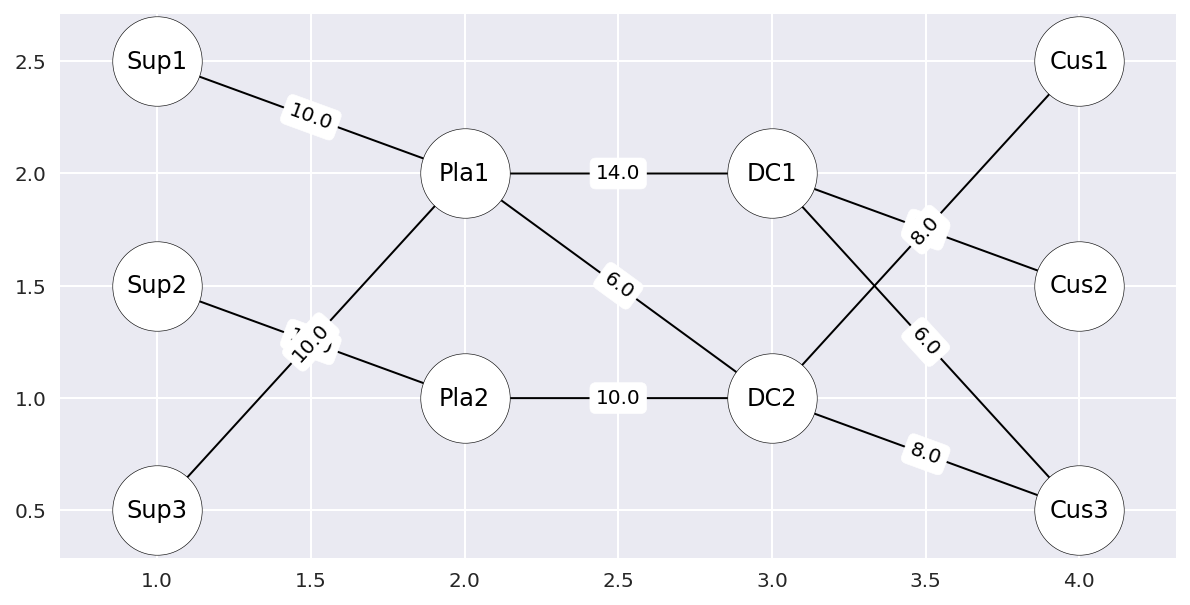

In [507]:
from utils import plot_graph
plot_graph(b, f, q[:-1])

In [467]:
def decode_chromosome(ch, E, D, W, d, t, a, c, dummy_supply, supply, demand):
    I = len(d)
    J = len(W)
    K = len(E)
#     print(ch)
    q = transportation_tree(W[:] + [dummy_supply], demand[:], c[:], 
                        ch[-2*I:-I], demand_limit=ch[-I:])
    f = transportation_tree(D[:], q[:-1].sum(1), a[:], 
                        ch[-J-2*I:-2*I])
    b = transportation_tree(supply[:], f.sum(1), t[:], 
                        ch[-K-J-2*I:-J-2*I])
    return q, f, b

In [241]:
q, f, b = decode_chromosome(list(ch) + [0.1, 0.1, 0.1], 
                                     E, D, W, d, t, a, c, dummy_supply, demand)

In [367]:
q, f, b = decode_chromosome([6.0, 1.0, 3.0, 4.0, 5.0, 2.0, 0.0, 0.7754266477209583, 0.947448101489923, 0.004218007841372051],
                            E, D, W, d, t, a, c, dummy_supply, demand)

[6.0, 1.0, 3.0, 4.0, 5.0, 2.0, 0.0, 0.7754266477209583, 0.947448101489923, 0.004218007841372051]

Initiating tree
Assign 62 from Plant 0 to Customer 1
Assign 75 from Plant 0 to Customer 2
Assign 18 from Plant 0 to Customer 1
Assign 5 from Plant 0 to Customer 2
Assign 50 from Plant 0 to Customer 3
Finished filling dummy
Assign 20 from Plant 2 to Customer 3
Assign 10 from Plant 1 to Customer 3
Finished

Initiating tree
Finished filling dummy
Assign 20 from Plant 1 to Customer 2
Assign 10.0 from Plant 2 to Customer 1
Finished

Initiating tree
Finished filling dummy
Assign 20.0 from Plant 1 to Customer 1
Assign 10.0 from Plant 3 to Customer 2
Finished


In [213]:
def evaluate_decoding(b, f, q, t, a, c):
    return np.multiply(b, t).sum() + \
           np.multiply(f, a).sum() + \
           np.multiply(q, c).sum()    

In [214]:
evaluate_decoding(b, f, q, t, a, c)

1302.0

In [226]:
def fairness(q):
    return sum([x**2 for x in q.sum(0)])

In [468]:
def chromosome_fitness(ch, E, D, W, d, t, a, c, dummy_supply, supply, demand):
    q, f, b = decode_chromosome(ch, E, D, W, d, t, a, c, dummy_supply, supply, demand)
    transp_cost = evaluate_decoding(b, f, q, t, a, c)
    fairness_cost = fairness(q[:-1])
    return transp_cost + fairness_cost

In [243]:
ch = [6, 4, 1, 5, 3, 2, 0] + [0.1, 0.1, 0.1]

In [245]:
chromosome_fitness(ch, E, D, W, d, t, a, c, dummy_supply, demand)

1626.0

## Genetic Algorithm

In [488]:
import random
from deap import creator, base, tools, algorithms

In [489]:
del creator.FitnessMin
del creator.Individual

In [490]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

In [491]:
N_NODES = 2 * len(d) + len(W) + len(D) 

In [492]:
def create_chromosome(permutation_size, demand_size):
    perm = np.random.permutation(permutation_size).astype(int)
    demand = np.random.uniform(size=demand_size)
    return list(perm) + list(demand)

In [493]:
toolbox = base.Toolbox()
toolbox.register('chromosome', create_chromosome, 
                permutation_size=len(d) + len(W) + len(D), 
                demand_size=len(d))
toolbox.register('individual', tools.initIterate, creator.Individual,
                toolbox.chromosome)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [494]:
from functools import partial
ga_fitness = lambda x: (partial(chromosome_fitness, E=E, 
                            D=D, W=W, d=d, t=t, a=a, c=c,
                            dummy_supply=dummy_supply, 
                            supply=supply,
                            demand=demand)(x),)

In [495]:
def custom_crossover(ind1, ind2, permutation_size):
    perm1 = ind1[:permutation_size]
    perm2 = ind2[:permutation_size]
    demand1 = ind1[permutation_size:]
    demand2 = ind2[permutation_size:]
    perm_child1, perm_child2 = tools.cxPartialyMatched(perm1, perm2)
    demand_child1, demand_child2 = tools.cxSimulatedBinaryBounded(
                                        demand1, demand2, 20, 0, 1)
    child1 = list(perm_child1) + list(demand_child1)
    child2 = list(perm_child2) + list(demand_child2)
    for i, x in enumerate(child1):
        ind1[i] = child1[i]
        ind2[i] = child2[i]
    return ind1, ind2

In [496]:
def custom_mutation(ind, permutation_size):
    perm = ind[:permutation_size]
    demand = ind[permutation_size:]
    perm_mut = tools.mutShuffleIndexes(perm, 2.0/len(perm))
    demand_mut = tools.mutPolynomialBounded(demand, 20, 0, 1, 1.0/len(demand))
    mut = list(perm_mut[0]) + list(demand_mut[0])
    for i, x in enumerate(mut):
        ind[i] = mut[i]
    return ind,

In [497]:
toolbox.register('evaluate', ga_fitness)
toolbox.register('mate', custom_crossover, 
                         permutation_size=len(d) + len(W) + len(D))
toolbox.register('mutate', custom_mutation,
                         permutation_size=len(d) + len(W) + len(D))
toolbox.register('select', tools.selTournament, tournsize=5)

In [510]:
pop = toolbox.population(n=50)
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('Avg', np.mean)
stats.register('Std', np.std)
stats.register('Min', np.min)
stats.register('Max', np.max)

In [511]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, 
                    stats=stats, halloffame=hof, verbose=True)

gen	nevals	Avg    	Std    	Min 	Max 
0  	50    	2093.86	202.206	1710	2300
1  	27    	1904.32	187.506	1679	2290
2  	32    	1796.3 	119.295	1656	2180
3  	32    	1753.48	163.482	1643	2290
4  	25    	1707.82	141.79 	1638	2280
5  	24    	1716.24	158.364	1638	2290
6  	40    	1767.02	196.903	1633	2290
7  	32    	1669.74	96.2401	1633	2180
8  	28    	1699.78	143.383	1633	2188
9  	27    	1707.2 	165.834	1633	2290
10 	36    	1644.2 	32.5804	1633	1785
11 	35    	1643.18	27.6237	1633	1771
12 	30    	1637.1 	13.5886	1633	1715
13 	22    	1645.4 	60.8539	1625	2059
14 	33    	1639.26	23.6785	1625	1763
15 	23    	1638.48	30.082 	1625	1760
16 	35    	1633.66	29.4582	1619	1784
17 	26    	1626.66	13.9952	1619	1723
18 	26    	1631.1 	30.9517	1619	1779
19 	33    	1631.82	29.931 	1619	1779
20 	31    	1630.26	31.6593	1619	1779
21 	31    	1634.84	36.2041	1619	1779
22 	34    	1630.88	34.8974	1619	1789
23 	35    	1626.36	22.4239	1619	1715
24 	26    	1629.38	31.3049	1619	1779
25 	25    	1631.9 	42.402 	1619	1821
2

In [512]:
q, f, b = decode_chromosome(hof.items[0], E, D, W, d, t, a, c, 
                            dummy_supply, supply, demand)

In [513]:
q

array([[ 0., 10.,  0.],
       [11.,  0.,  9.],
       [69., 70., 71.]])

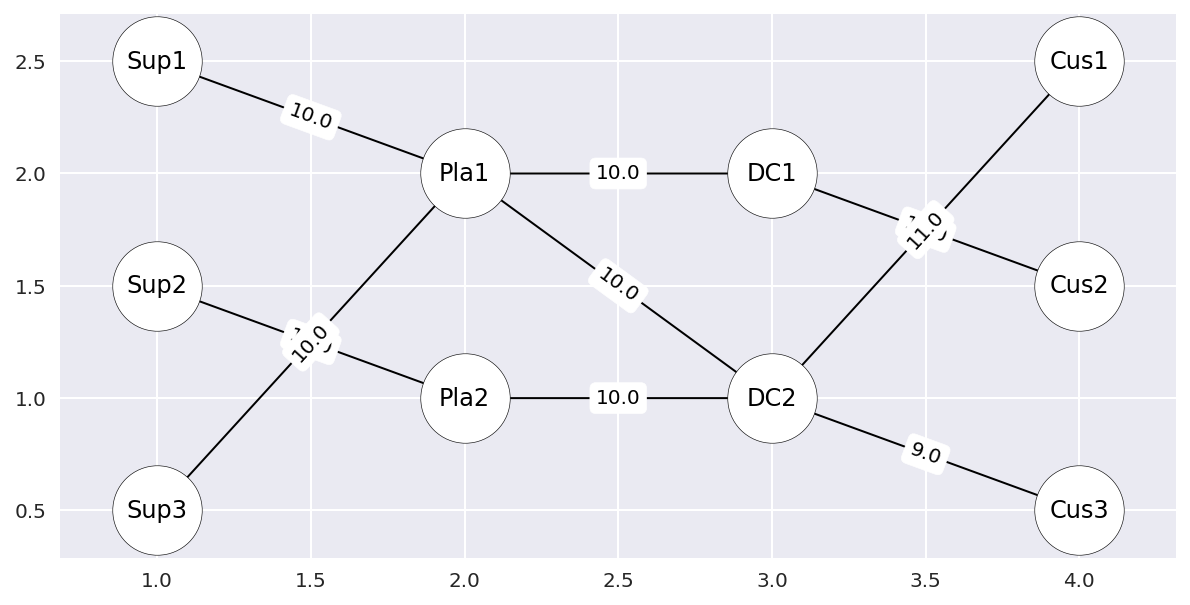

In [514]:
plot_graph(b, f, q[:-1])

In [ ]:
# mse of % of satisfaction
# no cap bottlenecks